In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import tqdm
import utils as utils
import scienceplots
plt.style.use('science')

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_FaIRGP as fairgp
import fit_Plain_GP as plaingp

In [3]:
def predict(gpmodel, fairgpmodel, test_data):
    test_scenarios = test_data.scenarios
    test_times = test_scenarios.timesteps
    test_tas = test_scenarios.tas
    test_tas_fair = fairgpmodel._compute_mean(test_scenarios)
    X_test = torch.cat([test_scenarios.cum_emissions[:, 0, None],
                        test_scenarios.emissions[:, 1:]], dim=-1)
    X_test = (X_test - gpmodel.mu) / gpmodel.sigma

    gpmodel = gpmodel.eval()
    fairgpmodel = fairgpmodel.eval()

    with torch.no_grad():
        gp_test_posterior = gpmodel(X_test)
        mean = gpmodel.sigma_targets * gp_test_posterior.mean + gpmodel.mu_targets
        covar = gpmodel.sigma_targets.pow(2) * gp_test_posterior.covariance_matrix
        gp_test_posterior = gp_test_posterior.__class__(mean, gpytorch.add_jitter(covar))

        noisy_gp_test_posterior = gpmodel.likelihood(gpmodel(X_test))
        mean = gpmodel.sigma_targets * noisy_gp_test_posterior.mean + gpmodel.mu_targets
        covar = gpmodel.sigma_targets.pow(2) * noisy_gp_test_posterior.covariance_matrix
        noisy_gp_test_posterior = noisy_gp_test_posterior.__class__(mean, covar)

    with torch.no_grad():   
        fairgp_test_posterior = fairgpmodel(test_scenarios)
        noisy_fairgp_test_posterior = fairgpmodel.likelihood(fairgp_test_posterior)

    gp_posterior_mean = noisy_gp_test_posterior.mean
    gp_posterior_lb, gp_posterior_ub = gp_test_posterior.confidence_region()
    gp_posterior_lb = gp_posterior_lb.detach()
    gp_posterior_ub = gp_posterior_ub.detach()

    noisy_gp_posterior_lb, noisy_gp_posterior_ub = noisy_gp_test_posterior.confidence_region()
    noisy_gp_posterior_lb = noisy_gp_posterior_lb.detach()
    noisy_gp_posterior_ub = noisy_gp_posterior_ub.detach()

    fairgp_posterior_mean = fairgp_test_posterior.mean + test_tas_fair
    fairgp_posterior_lb, fairgp_posterior_ub = fairgp_test_posterior.confidence_region()
    fairgp_posterior_lb = fairgp_posterior_lb.detach() + test_tas_fair
    fairgp_posterior_ub = fairgp_posterior_ub.detach() + test_tas_fair

    noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub = noisy_fairgp_test_posterior.confidence_region()
    noisy_fairgp_posterior_lb = noisy_fairgp_posterior_lb.detach() + test_tas_fair
    noisy_fairgp_posterior_ub = noisy_fairgp_posterior_ub.detach() + test_tas_fair
    
    pred = {'gp_posterior_mean': gp_posterior_mean,
            'gp_posterior_lb': gp_posterior_lb,
            'gp_posterior_ub': gp_posterior_ub,
            'noisy_gp_posterior_lb': noisy_gp_posterior_lb,
            'noisy_gp_posterior_ub': noisy_gp_posterior_ub,
            'fairgp_posterior_mean': fairgp_posterior_mean,
            'fairgp_posterior_lb': fairgp_posterior_lb,
            'fairgp_posterior_ub': fairgp_posterior_ub,
            'noisy_fairgp_posterior_lb': noisy_fairgp_posterior_lb,
            'noisy_fairgp_posterior_ub': noisy_fairgp_posterior_ub,
            'test_tas_fair': test_tas_fair,
            'test_tas': test_tas,
            'test_times': test_times}
    return pred

#### Predict on SSP126

In [4]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp245', 'ssp370', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp126']}}
test_data = plaingp.make_data(test_cfg)

gpmodel = plaingp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp126/PlainGP/state_dict.pt')
gpmodel.load_state_dict(state_dict)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp126/FaIRGP/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)

pred_ssp126 = predict(gpmodel, fairgpmodel, test_data)

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


#### Predict on SSP245

In [5]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp370', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp245']}}
test_data = plaingp.make_data(test_cfg)

gpmodel = plaingp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp245/PlainGP/state_dict.pt')
gpmodel.load_state_dict(state_dict)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp245/FaIRGP/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)

pred_ssp245 = predict(gpmodel, fairgpmodel, test_data)

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


#### Predict on SSP585

In [6]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp370']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp585']}}
test_data = plaingp.make_data(test_cfg)

gpmodel = plaingp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp585/PlainGP/state_dict.pt')
gpmodel.load_state_dict(state_dict)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp585/FaIRGP/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)

pred_ssp585 = predict(gpmodel, fairgpmodel, test_data)

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


### Make plot

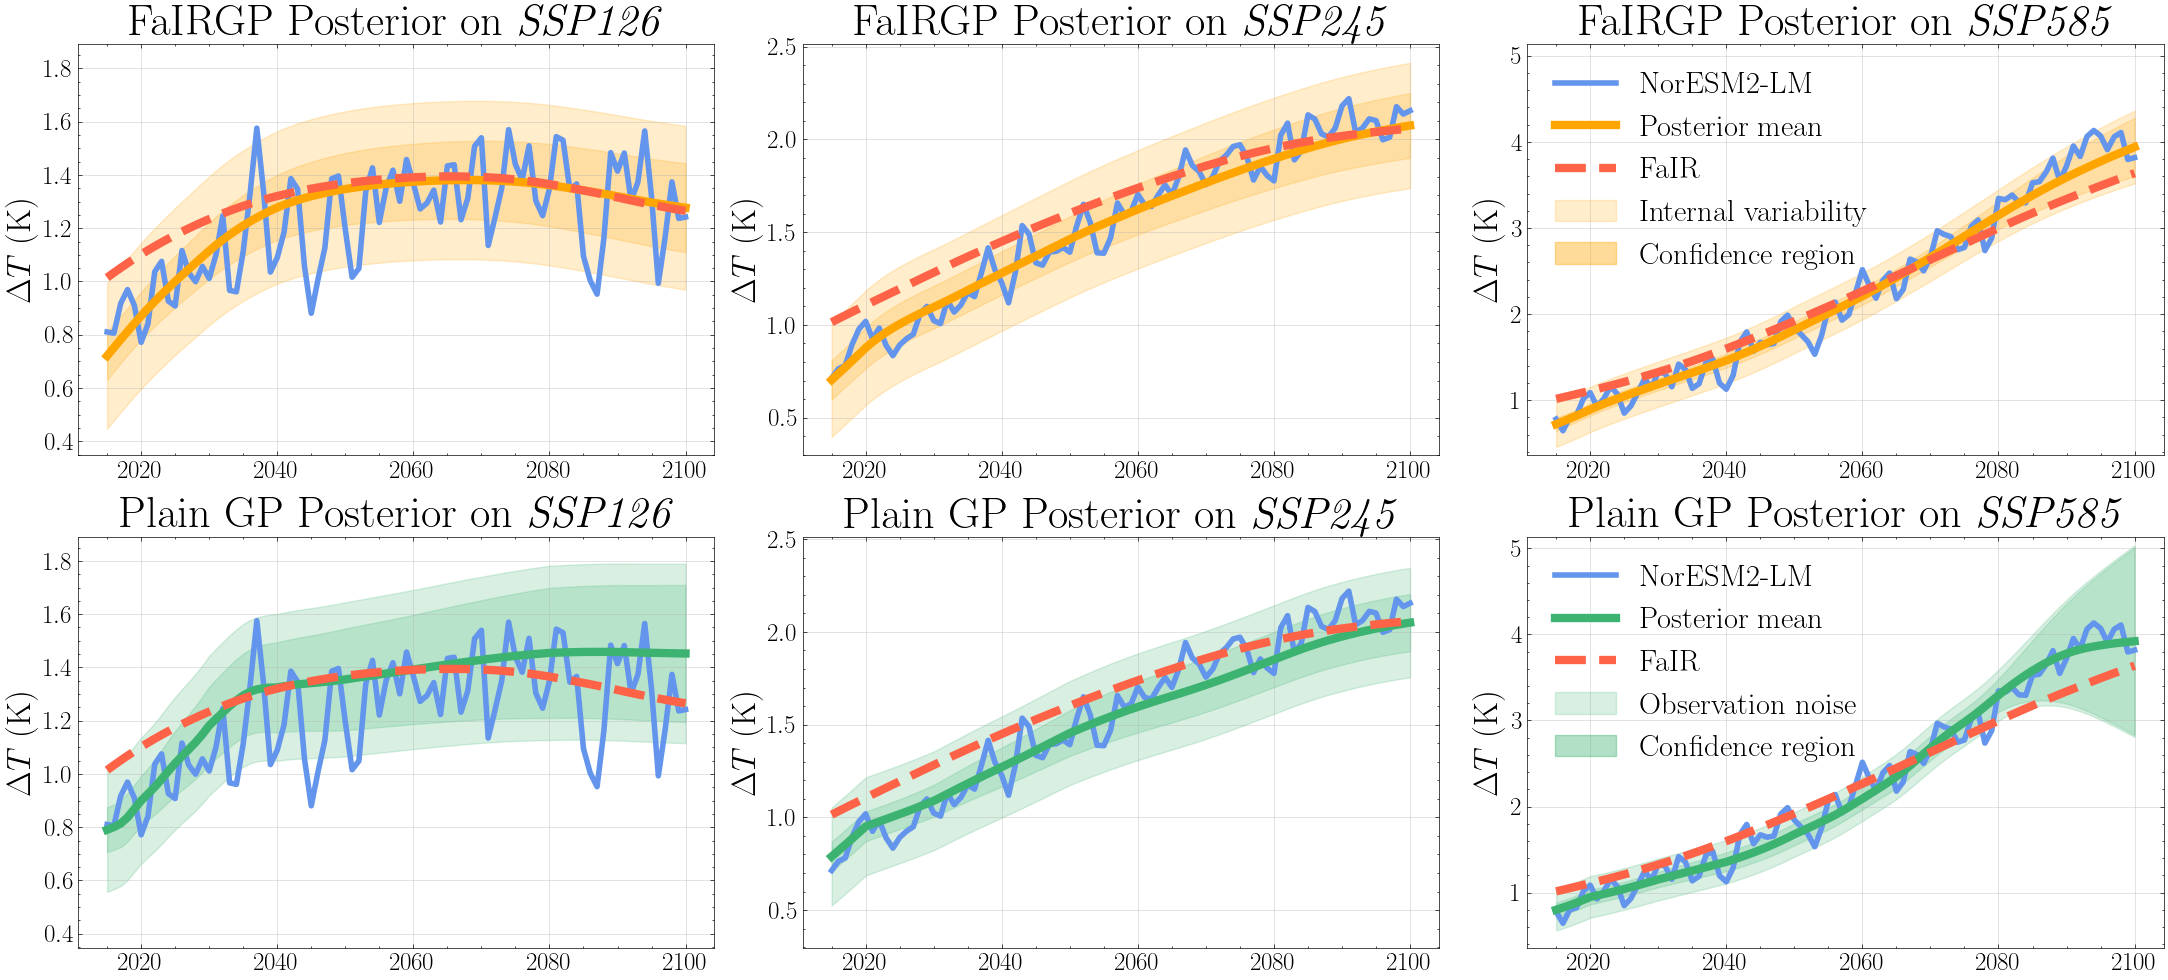

In [8]:
preds = {'SSP126': pred_ssp126, 'SSP245': pred_ssp245, 'SSP585': pred_ssp585}

title_size = 32
label_size = 24
ticks_size = 18
legend_size = 22

fig, ax = plt.subplots(2, 3, figsize=(22, 10))
    
for i, (name, pred_dict) in enumerate(preds.items()):
    test_times = pred_dict['test_times']
    test_tas = pred_dict['test_tas']
    test_tas_fair = pred_dict['test_tas_fair']
    gp_posterior_mean = pred_dict['gp_posterior_mean']
    gp_posterior_lb = pred_dict['gp_posterior_lb']
    gp_posterior_ub = pred_dict['gp_posterior_ub']
    noisy_gp_posterior_ub = pred_dict['noisy_gp_posterior_ub']
    noisy_gp_posterior_lb = pred_dict['noisy_gp_posterior_lb']
    fairgp_posterior_mean = pred_dict['fairgp_posterior_mean']
    fairgp_posterior_lb = pred_dict['fairgp_posterior_lb']
    fairgp_posterior_ub = pred_dict['fairgp_posterior_ub']
    noisy_fairgp_posterior_lb = pred_dict['noisy_fairgp_posterior_lb']
    noisy_fairgp_posterior_ub = pred_dict['noisy_fairgp_posterior_ub']
    
    ymax = max(noisy_fairgp_posterior_ub.max(), noisy_gp_posterior_ub.max()) + 0.1
    ymin = min(noisy_fairgp_posterior_lb.min(), noisy_gp_posterior_lb.min()) - 0.1

    ax[0, i].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='NorESM2-LM')
    ax[0, i].plot(test_times, fairgp_posterior_mean, color='orange', lw=6, label='Posterior mean')
    ax[0, i].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
    ax[0, i].fill_between(test_times, fairgp_posterior_lb, fairgp_posterior_ub, alpha=0.2, color='orange',
                       label='Internal variability')
    ax[0, i].fill_between(test_times, noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub, alpha=0.2, color='orange',
                       label='Confidence region')
    ax[0, i].tick_params(labelsize=ticks_size)
    ax[0, i].grid(alpha=0.5)
    ax[0, i].set_ylim(ymin, ymax)
    ax[0, i].set_ylabel(r'$\Delta T$ (K)', fontsize=label_size)
    ax[0, i].set_title(f'FaIRGP Posterior on $\it {name}$', fontsize=title_size)
    
    
    ax[1, i].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='NorESM2-LM')
    ax[1, i].plot(test_times, gp_posterior_mean, color='mediumseagreen', lw=6, label='Posterior mean')
    ax[1, i].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
    ax[1, i].fill_between(test_times, gp_posterior_lb, gp_posterior_ub, alpha=0.2, color='mediumseagreen',
                       label='Observation noise')
    ax[1, i].fill_between(test_times, noisy_gp_posterior_lb, noisy_gp_posterior_ub, alpha=0.2, color='mediumseagreen',
                   label='Confidence region')
    ax[1, i].tick_params(labelsize=ticks_size)
    ax[1, i].grid(alpha=0.5)
    ax[1, i].set_ylim(ymin, ymax)
    ax[1, i].set_ylabel(r'$\Delta T$ (K)', fontsize=label_size)
    ax[1, i].set_title(f'Plain GP Posterior on $\it {name}$', fontsize=title_size)


    
    
legend = ax[0, -1].legend(loc='upper left', fontsize=legend_size)
legend.legendHandles[4].set_alpha(0.4)
    
legend = ax[1, -1].legend(loc='upper left', fontsize=legend_size)
legend.legendHandles[4].set_alpha(0.4)
    
plt.tight_layout()
plt.savefig('./figures/SSP-experiment-paper-plot.png', dpi=200)
plt.show()